In [1]:
# IPython magic to import matplotlib and plot inline
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np                    #
from fenics import *                  # imports the fenics package
import os                             # allows to use path
import time                           # allows to measure real time
import pandas as pd                   # allows to manage with numerical data

In [2]:
# Path settings
# we use a relative path here, you can also specify an absolute path for your system
out_path = "output20"
os.makedirs(out_path, exist_ok=True)

In [3]:
# Time dimension parameters
t_0 = 0                    # initial time
t_f = 1.0                  # final time
num_steps = 10             # number of time steps
dt = (t_f-t_0) / num_steps # time step size

In [4]:
# Create mesh
length = 5
thickness = 5
height = 5
nelements = 20

mesh = BoxMesh(Point(-length/2, -thickness/2, -height/2), Point(length/2, thickness/2, height/2), nelements, nelements, nelements)
# Surface normals of the cube
normals = FacetNormal(mesh)
mesh

In [5]:
# Define a function space
V = VectorFunctionSpace(mesh, 'Lagrange',1)

In [6]:
# Create class that defines subdomains for bondaries conditions (inherits from fenics.SubDomain)
class LowerSide(SubDomain):
    def inside(self, x, on_boundary):
        tol = 1E-14
        return on_boundary and near(x[2], -height/2, tol)
    
class UpperSide(SubDomain):
    def inside(self, x, on_boundary):
        tol = 1E-14
        return on_boundary and near(x[2], height/2, tol)

In [7]:
# Mark facets and save the result in .pvd file
domains_facets  = MeshFunction('size_t', mesh, mesh.geometric_dimension()-1)
domains_facets.set_all(0)

# Integration over subdomains
ds = Measure('ds', domain=mesh, subdomain_data=domains_facets)

# Mark bottom facets
bottom = LowerSide()
bottom.mark(domains_facets, 1)

# Mark upper facets
up = UpperSide()
up.mark(domains_facets, 2)

# Save in .pvd file
boundaries_file = File(os.path.join(out_path, "boundaries.pvd"))
boundaries_file << domains_facets

In [8]:
# Strain coefficient
Sc = 0.1

# Boundary conditions
u_0 = Constant((0,0,0))          # No displacement
u_t = Expression(('0','0','c*t/T'), degree=1,c=Sc*height, t=0, T=t_f)          # Traction
u_c = Expression(('0','0','c*t/T'), degree=1,c=-Sc*height, t=0, T=t_f)         # Compression
u_s = Expression(('2*c*t/T','0','0'), degree=1,c=Sc*height, t=0, T=t_f)          # Shearing

u_1 = u_t

# Define bc as u_0 in the vector space V on the subdomain domains_facets labeled by 1 (lower facets)
bcl = DirichletBC(V, u_0, domains_facets, 1)
bcu = DirichletBC(V, u_1, domains_facets, 2)
bcs = [bcl, bcu]

In [9]:
# Define functions
du = TrialFunction(V)            # Incremental displacement
v  = TestFunction(V)             # Test function
u  = Function(V)                 # Displacement from previous iteration
B  = Constant((0.0, 0.0, -0.5))  # Body force per unit volume

In [10]:
# Kinematics
d = u.geometric_dimension()
I = Identity(d)                  # Identity tensor
F = I + grad(u)                  # Deformation gradient
F = variable(F)                  # !!! needed to be able to differentiate strain energydensity function wrt F for stress computation
C = F.T*F                        # Right Cauchy-Green tensorb

In [11]:
# Invariants of deformation tensors
Ic = tr(C)
J  = det(F)

In [12]:
# Elasticity parameters
alpha = -26.6
mu    = 0.35
nu    = 0.49
E     = Constant(2*mu*(1+nu))
print('E = ',float(E))
lmbda = Constant(2*mu*nu/(1-2*nu))
print('lambda = ',float(lmbda))
kappa = Constant(2*mu*(1+nu)/(3*(1-2*nu)))
print('kappa = ',float(kappa))

E =  1.043
lambda =  17.149999999999984
kappa =  17.383333333333315


In [13]:
# Stored strain energy density (compressible neo-Hookean model)
psi = (mu/2)*(Ic - 3) - mu*ln(J) + (lmbda/2)*(ln(J))**2

In [14]:
def Psi2Solver(Psi):
    # Total potential energy
    # Pi = psi*dx - dot(B, u)*dx    # without traction force, with body force B
    Pi = psi*dx                   # without traction force, without body force B
    
    # Compute first variation of Pi (directional derivative about u in the direction of v)
    Fpi = derivative(Pi, u, v)
    
    # Compute Jacobian of Fpi
    Jac = derivative(Fpi, u, du)
    
    # Define the solver
    problem = NonlinearVariationalProblem(Fpi, u, bcs, Jac)
    solver = NonlinearVariationalSolver(problem)
    
    # Set solver parameters (optional)
    prm = solver.parameters
    prm['nonlinear_solver'] = 'newton'
    prm['newton_solver']['linear_solver'] = 'cg'
    prm['newton_solver']['preconditioner'] = 'icc'
    
#     prm['newton_solver']['error_on_nonconvergence'] = True
#     prm['newton_solver']['absolute_tolerance'] = 1E-9
#     prm['newton_solver']['relative_tolerance'] = 1E-8
#     prm['newton_solver']['maximum_iterations'] = 100
#     prm['newton_solver']['relaxation_parameter'] = 1.0
    
#     prm['newton_solver']['lu_solver']['report'] = True
# #     prm['newton_solver']['lu_solver']['reuse_factorization'] = False
# #     prm['newton_solver']['lu_solver']['same_nonzero_pattern'] = False
#     prm['newton_solver']['lu_solver']['symmetric'] = False

#     prm['newton_solver']['krylov_solver']['error_on_nonconvergence'] = True
#     prm['newton_solver']['krylov_solver']['absolute_tolerance'] = 1E-7
#     prm['newton_solver']['krylov_solver']['relative_tolerance'] = 1E-5
#     prm['newton_solver']['krylov_solver']['maximum_iterations'] = 1000
#     prm['newton_solver']['krylov_solver']['nonzero_initial_guess'] = True
    
    return solver

In [15]:
# Compute initial guess
solver = Psi2Solver(psi)

# Set time for non 0 displacement
t = t_0+dt
u_1.t = t

# Compute solution
solver.solve()

# Update displacement field with initial guess
u.assign(u)

In [16]:
# Invariants 
def I1(T):
    return tr(T)

def I2(T):
    t1 = T[0,0]*T[1,1] + T[0,0]*T[2,2] + T[1,1]*T[2,2]
    t2 = T[0,1]*T[0,1] + T[0,2]*T[0,2] + T[1,2]*T[1,2]
    return t1 - t2

def I3(T):
    return det(T)

# Define function necessary for eigenvalues computation
def v_inv(T):
    return (I1(T)/3.)**2 - I2(T)/3.

def s_inv(T):
    return (I1(T)/3.)**3 - I1(T)*I2(T)/6. + I3(T)/2.

def phi_inv(T):
    arg = s_inv(T)/v_inv(T)*sqrt(1./v_inv(T))
    # numerical issues if arg~0 -> https://fenicsproject.org/qa/12299/nan-values-when-computing-arccos-1-0-bug/
    arg_cond = conditional( ge(arg,  1-DOLFIN_EPS),  
                                     1-DOLFIN_EPS, 
                                     conditional( le(arg, -1+DOLFIN_EPS), -1+DOLFIN_EPS, arg ))
    return acos(arg_cond)/3.

In [17]:
# Eigenvalues of the strech tensor C
lambda_1 = Ic/3. + 2*sqrt(v_inv(C))*cos(phi_inv(C))
lambda_2 = Ic/3. - 2*sqrt(v_inv(C))*cos(pi/3. + phi_inv(C))
lambda_3 = Ic/3. - 2*sqrt(v_inv(C))*cos(pi/3. - phi_inv(C))

In [18]:
# Stored strain energy density (modified one-term Ogden model)
Ogd_iso = 2 * mu * (J**(-1/3)*lambda_1**(alpha/2.) + J**(-1/3)*lambda_2**(alpha/2.) + J**(-1/3)*lambda_3**(alpha/2.) - 3) / alpha**2
Ogd_vol = kappa * (J**2-1-2*ln(J))
psi = Ogd_iso + Ogd_vol

In [19]:
# Create XMDF file for the solution
results = xdmffile = XDMFFile(os.path.join(out_path, 'results-OgdenComp.xdmf'))
results.parameters["flush_output"] = True
results.parameters["functions_share_mesh"] = True

In [20]:
# Time-stepping
t = t_0
Atime = []
Stime = []
Rf_lo = []
Rf_up = []
State = []
Pstress = []

solver = Psi2Solver(psi)

for i in range(num_steps+1):
    
    print("Actual time:   ", t , "s")

    # Update current time
    Atime.append(t)
    u_1.t = t

    # Compute solution
    tic = time.clock()
    solver.solve()
    toc = time.clock()
    
    # Save solving time in an array
    Stime.append(toc-tic)
    
    # compute max / min displacement
    W = FunctionSpace(mesh, 'P', 1)

    u_magnitude = sqrt(dot(u, u))
    u_magnitude = project(u_magnitude, W)
    print('Min/Max displacement:',
          u_magnitude.vector().get_local().min(),
          u_magnitude.vector().get_local().max())

    # Computation of the stresses
    Z = TensorFunctionSpace(mesh, 'P', 1)
    print("Stress derivation and saving to file")
    S = diff(psi, F)            # compute material stress by differentiation of psi!
    S_project = project(S, Z, solver_type='cg')
    S_project.rename("Material stress (MPa)", "")
    
    # Computation of van Mises Stress
    s = S - (1./3) * tr(S) * Identity(u.geometric_dimension())     # compute the stress deviator
    von_Mises = sqrt( 3./2 * inner(s, s) )
    von_Mises_project = project(von_Mises, W)
    von_Mises_project.rename("Von Mises stress (MPa)", "")
    print("Maximum equivalent stress:", von_Mises_project.vector().get_local().max())
    
    # Computation of reaction forces
    T = inv(det(F)) * F * S * F.T                          # Cauchy stress tensor
    T_project = project(T, Z, solver_type='cg')
    T_project.rename("Spatial stress (MPa)", "")
    tn = dot(T,normals)                                    # Cauchy stress vectors
    Rf_lo.append(assemble(inner(tn,normals)*ds(1)))        # normal reaction force on lower surface
    Rf_up.append(assemble(inner(tn,normals)*ds(2)))        # normal reaction force on upper surface
    
    # Compute values for plot
    State.append(((Sc*height*t/t_f)+height)/height)
    Pstress.append(assemble(inner(tn,normals)*ds(2))/(length*thickness))
    
    # Control change of volume
    J_project = project(J, W)
    J_project.rename("J (-)","")
    
    # Save results in XMDF format 
    u.rename("Displacement field (mm)","")
    results.write(u,t)
    results.write(S_project,t)
    results.write(von_Mises_project,t)
    results.write(T_project,t)
    results.write(J_project,t)

    # Update previous solution
    u.assign(u)
    
    # Update time
    t += dt

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Actual time:    0 s
Min/Max displacement: -2.80173027813e-06 0.000934301219301
Stress derivation and saving to file
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
           Consider using the option 'quadrature_degree' to reduce the number of points
Maximum equivalent stress: 0.000782357753227
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Actual time:    0.1 s
Min/Max displacement: -1.02055846551e-05 0.0500000939963
Stress derivation and saving to file
Maximum equivalent stress: 0.0198641433015
Actual time:    0.2 s
Min/Max displacement: -1.85070431778e-05 0.100000190448
Stress derivation and saving to file
Maximum equival

    Solving Time (s)  Time (s)  Reaction Force on base (N)  \
0          17.379287       0.0                   -0.103457   
1          17.453714       0.1                    2.593820   
2          17.760782       0.2                    5.119909   
3          17.465339       0.3                    7.559091   
4          17.371605       0.4                    9.975781   
5          17.432837       0.5                   12.415034   
6          17.437357       0.6                   14.906058   
7          17.334958       0.7                   17.466274   
8          18.045073       0.8                   20.104874   
9          17.823173       0.9                   22.825616   
10         17.500908       1.0                   25.628959   

    Reaction Force (N)  Stretch (-)  Nominal stress (MPa)  
0            -0.103457         1.00             -0.004138  
1             2.593820         1.01              0.103753  
2             5.119909         1.02              0.204796  
3             7

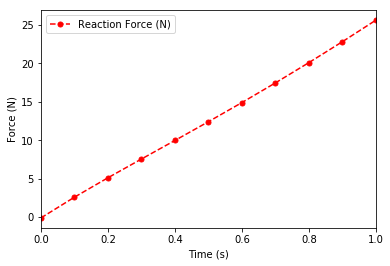

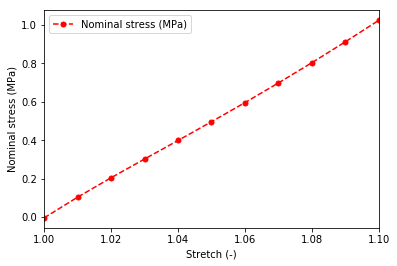

In [21]:
data = {'Solving Time (s)':Stime,
        'Time (s)':Atime,
        'Reaction Force on base (N)':Rf_lo,
        'Reaction Force (N)':Rf_up,
        'Stretch (-)':State,
        'Nominal stress (MPa)':Pstress}
 
# Create DataFrame
df = pd.DataFrame(data)
 
# Print the output.
print(df)
ax = df.plot(x='Time (s)',y='Reaction Force (N)',color='red',marker='o',markersize=5,linestyle='--')
ax.set_ylabel("Force (N)")
df.to_pickle('Output Data - OgdenComp')
plt.savefig('ReactionForce - OgdenComp.pdf')

ax = df.plot(x='Stretch (-)',y='Nominal stress (MPa)',color='red',marker='o',markersize=5,linestyle='--')
ax.set_ylabel("Nominal stress (MPa)")
df.to_pickle('Output Stress- OgdenComp')
plt.savefig('NominalStress - OgdenComp.pdf')